# Seatlle Airbnb Open Data Analysis

On this opportunity, we will explore housing data on Seattle, provided by Airbnb.

In [8]:
#install the necessary packages. To install nltk package when we use python on our local computer, we will need to have Visual Studio Build Tools (just follow the instruction when installing)
!pip install nltk
!pip install langdetect
!pip install wordcloud

     |████████████████████████████████| 981 kB 13.7 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=12fa851d9ed5a6fb5ce952cb3dd91086ab5d47c1c3bbe339317e714d19974ede
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [1]:
#load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

There are 3 tables provided for each region : calendar.csv , listings.csv, and reviews.csv.

In [2]:
#load the necessary tables
calendar = pd.read_csv("/content/calendar.csv")
listings = pd.read_csv("/content/listings.csv")
reviews = pd.read_csv("/content/reviews.csv")

Some interesting business related questions are :

1.   How occupied were the Airbnb housings in Seattle?
2.   Is there any significant differences of average reviews scores between neighbourhood groups?
3.   How good or bad were the sentiments of the users to the housings?



### 1. Evaluating the occupancy of housing in Seattle

In [53]:
#Range of dates
print(calendar['date'].max())
print(calendar['date'].min())

2017-01-02 00:00:00
2016-01-04 00:00:00


In [25]:
# count the number of listed housings
count_all_listing = len(calendar['listing_id'].unique())
print(count_all_listing)

3818


In [26]:
#group by listing id and availability, then count the dates
summary_calendar = calendar.groupby(['listing_id', 'available'])['date'].count().reset_index()

In [27]:
# how many housings never be occupied during the whole year period?
count_idle_housing = len(summary_calendar[(summary_calendar['date']==365) & (summary_calendar['available']=="t")])
print(count_idle_housing)

678


In [28]:
prop_idle_housing = len(summary_calendar[(summary_calendar['date']==365) & (summary_calendar['available']=="t")])/len(calendar['listing_id'].unique())
print(prop_idle_housing)

0.17757988475641698


In [29]:
# how many housings always occupied everyday throughout the year?
len(summary_calendar[(summary_calendar['date']==365) & (summary_calendar['available']=="f")])

95

In [30]:
#how is the distribution of the occupancy? (available = "f")
distribution_of_occupancy = summary_calendar[summary_calendar['available']=="f"]
distribution_of_occupancy['date'].describe()

count    3140.000000
mean      146.187261
std       125.484371
min         1.000000
25%        23.000000
50%       118.000000
75%       272.000000
max       365.000000
Name: date, dtype: float64

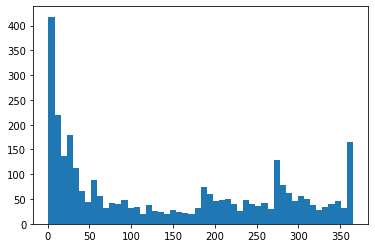

In [ ]:
#plot the distribution of day of occupancy for each housing
plt.hist(np.asarray(distribution_of_occupancy['date']), bins = 50)
plt.show()

Any influence of season?

In [32]:
#group by date then count how many housings were booked each day
summary_calendar_daily = calendar[calendar['available']=="f"].groupby(['date'])['available'].count().reset_index()
summary_calendar_daily

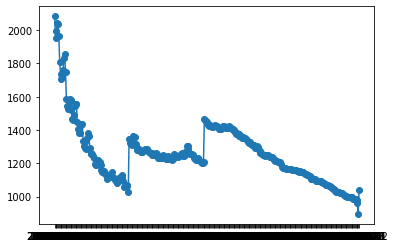

In [44]:
plt.plot_date(summary_calendar_daily['date'], summary_calendar_daily['available'], linestyle ='solid')

From the above plot we can see the significant decrease of occupancy overtime, except some moments where it increased on April & July

### 2. Evaluating the rating of housing in Seattle by neighbourhood group

In [58]:
#What are the neighbourhood groups
listings['neighbourhood_group_cleansed'].unique()

array(['Queen Anne', 'Ballard', 'Other neighborhoods', 'Cascade',
       'Central Area', 'University District', 'Downtown', 'Magnolia',
       'West Seattle', 'Interbay', 'Beacon Hill', 'Rainier Valley',
       'Delridge', 'Seward Park', 'Northgate', 'Capitol Hill',
       'Lake City'], dtype=object)

As there are some missing values in review_scores_rating, we should fill them. I decided to go with the average score, because it should represent the majority of the listings conditions, which is appropriate to approximate the unknown ratings of those listings.

In [71]:
#calculate the average score of review_scores_rating on overall data
average_score = listings['review_scores_rating'].mean()
average_score

94.53926206244176

In [62]:
#fill na values with the average score
listings['review_scores_rating'].fillna(average_score, inplace=True)

In [68]:
#group by neighbourhood groups then calculate the mean
review_scores_rating_by_neighbourhood = listings.groupby(['neighbourhood_group_cleansed'])['review_scores_rating'].mean().reset_index()
review_scores_rating_by_neighbourhood

,neighbourhood_group_cleansed,review_scores_rating
0,Ballard,95.373707
1,Beacon Hill,94.085499
2,Capitol Hill,94.251677
3,Cascade,93.021823
4,Central Area,95.810198
5,Delridge,95.627211
6,Downtown,94.039444
7,Interbay,93.916229
8,Lake City,94.401968
9,Magnolia,93.959831


<BarContainer object of 17 artists>

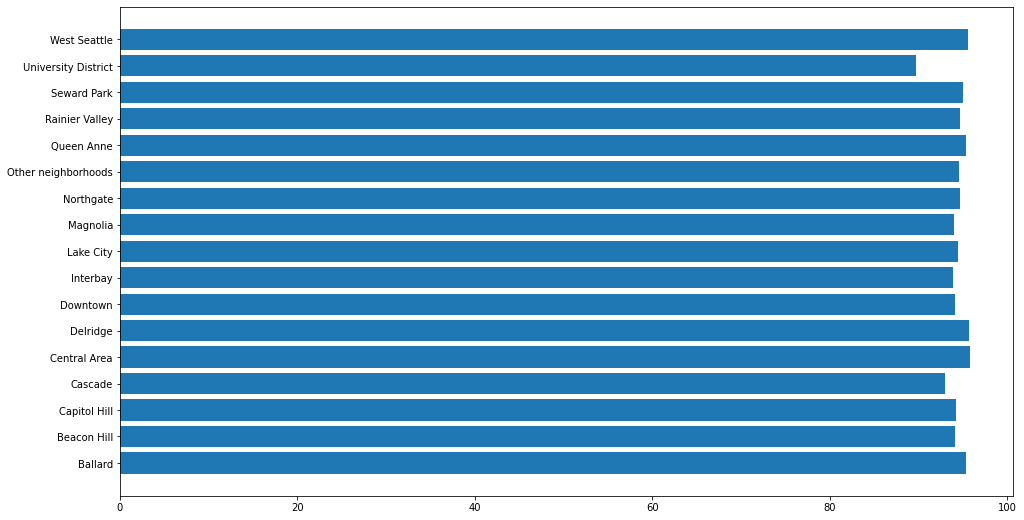

In [70]:
#draw a barplot to see the visualization
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(review_scores_rating_by_neighbourhood['neighbourhood_group_cleansed'],review_scores_rating_by_neighbourhood['review_scores_rating'])

We can see from the above plot that the differences are not significant. Most of the neighbourhood groups have average review score of around 93%–95%. The only exception was for University District, which only got a score of 89.73%.

## 3. Sentiment of reviews

We have reviews data, and we then can analyze the sentiment of these comments. We will subset the data to only the ones written in English language.

To analyze sentiment, we can use pretrained NLP model in nltk package (to learn more, please refer to https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c)

To detect what language the comments were written, we can use langdetect package(https://pypi.org/project/langdetect/)

First of all, let's see how many reviews written by each person.

We can see that Amanda (206203) had written most reviews(34)throughout the year.


In [5]:
#group by reviewer, then calculate how many reviews have been written by each reviewer
summary_reviews = reviews.groupby(["reviewer_id", "reviewer_name"])["listing_id"].nunique().reset_index().sort_values(by='listing_id', ascending=False)
summary_reviews

,reviewer_id,reviewer_name,listing_id
1190,206203,Amanda,34
38164,15121499,Kathryn,19
11568,2734499,Jason,18
70900,41158892,Paige,14
34522,12934633,Ryan,13
...,...,...,...
26700,8504586,Steve,1
26701,8504801,Stefanie,1
26702,8505385,Zachary,1
26703,8509635,小萱,1


In [6]:
#create new columns
reviews['score'] = ""
reviews['language'] = ""

In [10]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,score,language
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,en
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,en
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,en
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,en
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,en
...,...,...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...,0.9498,en
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...,0.8658,en
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del...",0.0,es
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si...",0.7468,en


In [9]:
#detect language and sentiment
from langdetect import detect
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for i in range(0, len(reviews)): 
  try :
    reviews['language'][i] = detect(reviews['comments'][i])
  except:
    pass
  if(isinstance(reviews['comments'][i], float)):
    reviews['score'][i] = None
  else :
    reviews['score'][i] = sid.polarity_scores(reviews['comments'][i])['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarn

Focus on reviews written with english language

In [11]:
#filter english language reviews
en_reviews = reviews[reviews['language']=="en"]

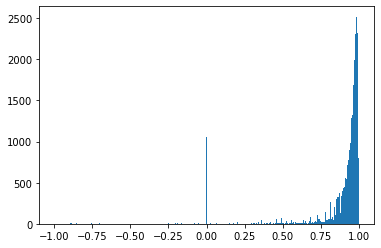

In [12]:
#plot the distribution of review scores
plt.hist(np.asarray(en_reviews['score']), bins = 1000)
plt.show()

We can see that most of the comments have positive sentiment (compound value > 0). On the other hand, many of the comments have sentiment score 0. Most of them are consist of automatically generated reviews.

If we want to improve our service, we should see what the bad reviews talk about. We can focus on the reviews having score < -0.7.

We can adjust the threshold to add more comments to our analysis, but sometimes the scores nearer to 0 mix up the sentiment. We should improve the model in the future

In [13]:
#put all reviews with score < -0.7 to bad_reviews
bad_reviews = en_reviews[en_reviews['score']<-0.7]
bad_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,score,language
1327,3426639,56532405,2015-12-14,12347322,Zachary,Leah was very responsive and attentive. When I...,-0.8725,en
2147,6228959,33045696,2015-05-24,27050071,Emmanuelle,"At first time, Pj was nice and answer quickly ...",-0.8537,en
2886,6004058,51017020,2015-10-17,39938930,Madelyn T,"Great neighborhood, but the ""patio"" photo was ...",-0.8551,en
4209,392779,1746817,2012-07-19,1454346,Joe,"According to Jyoti, ""Break-ins are a common oc...",-0.7086,en
4881,2284536,25130010,2015-01-07,20322264,Chris,I was disappointed in the rental. It had no t...,-0.9306,en
...,...,...,...,...,...,...,...,...
80563,3282000,19480623,2014-09-13,5006204,Angelos,Jessica and Rob were gracious hosts and you ca...,-0.7356,en
80734,6675927,39952566,2015-07-27,35730555,Keisha-Mae,"I was not welcomed by the host, but his partne...",-0.9151,en
80851,8474294,51219173,2015-10-18,44631,Bradford,"A beautiful, clean house in a convenient locat...",-0.9783,en
82885,92835,2462287,2012-10-01,2701462,Stuart,Lauren was very helpful by email after we had ...,-0.7536,en


To help us pinpoint the problems, we can make wordcloud (learn more : https://www.datacamp.com/community/tutorials/wordcloud-python)

In [14]:
#import the libraries for wordcloud
from wordcloud import WordCloud, STOPWORDS

In [21]:
def wordcloud_generator(data, column_of_words):
  """
  Wordcloud Generator
  Given a table with a column consists of words, this function will generate a wordcloud. 
  It assumes that STOPWORDS from wordcloud library has been loaded (from wordcloud import STOPWORDS).

  Parameters :
  data : the table which has a column containing of words to make the wordcloud from
  column_of_words : the column name (example : 'comments') which contains the words

  Returns :
  An image of wordcloud generated

  """


  text = " ".join(comment for comment in data[column_of_words]) #combine all the words in the reviews
  stopwords = set(STOPWORDS) #setup the stopwords
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text) #build the wordcloud
  plt.imshow(wordcloud, interpolation='bilinear') #show the wordcloud
  plt.axis("off")
  plt.show() 

Then, we can make a wordcloud from these bad reviews

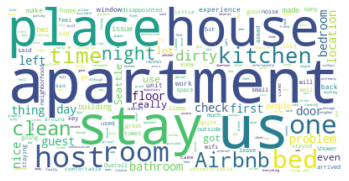

In [22]:
wordcloud_generator(bad_reviews, 'comments')

On the other hand, we can analyze the good comments, as a threshold, let's choose the comments with score > 0.7

In [23]:
#put all reviews with score > 0.7 to good_reviews
good_reviews = en_reviews[en_reviews['score']>0.7]
good_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,score,language
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,en
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,en
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,en
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,en
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,en
...,...,...,...,...,...,...,...,...
84843,3624990,49768901,2015-10-06,37578535,Michael,Comfortability upon arrival and everything wit...,0.9383,en
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...,0.9498,en
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...,0.8658,en
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si...",0.7468,en


Then, we can make a wordcloud from these good reviews as well

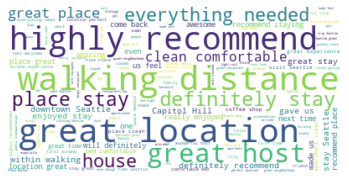

In [24]:
wordcloud_generator(good_reviews, 'comments')

## Additional : Geospatial Visualization

Reference : https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db

In [ ]:
longlat = listings[['latitude', 'longitude']]

In [ ]:
boundaries = ((longlat.longitude.min(),   longlat.longitude.max(),      
         longlat.latitude.min(), longlat.latitude.max()))

In [ ]:
boundaries

(-122.4172188142562, -122.2406070305399, 47.50508834369015, 47.73335790856482)

Open https://www.openstreetmap.org/ and input these boundaries, then export to png format, just like shown below :

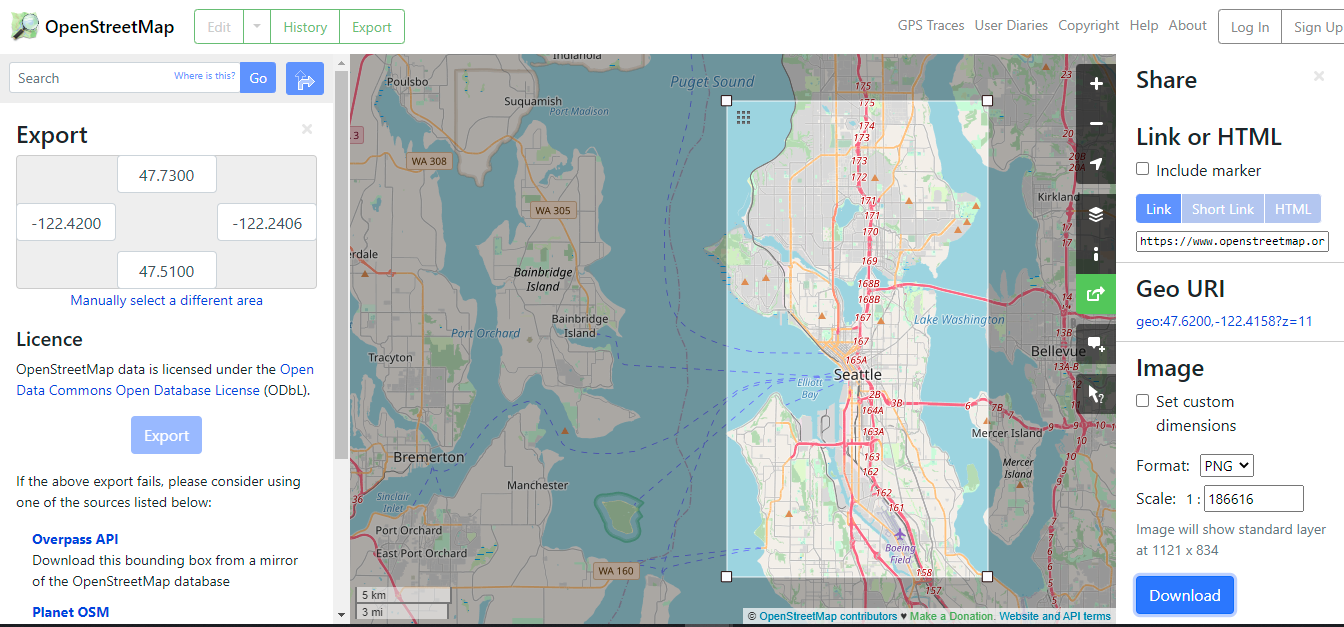

Load the image, then plot the longitude & latitudes

In [ ]:
seattle_map = plt.imread("/content/map.png")

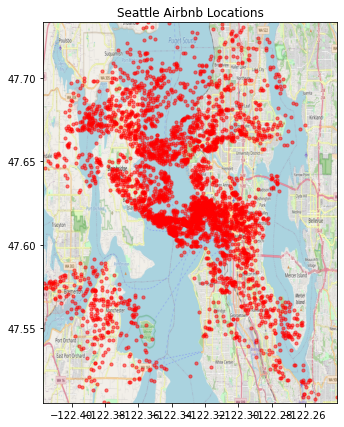

In [ ]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(longlat.longitude, longlat.latitude, zorder=1, alpha= 0.5, c='red', s=10)
ax.set_title('Seattle Airbnb Locations')
ax.set_xlim(boundaries[0],boundaries[1])
ax.set_ylim(boundaries[2],boundaries[3])
ax.imshow(seattle_map , zorder=0, extent = boundaries, aspect= 'equal')